# Predicting Airline Data using a Generalized Linear Model (GLM) in Tensorflow

In particular, we will predict the probability that a flight is late based on its departure date/time, the expected flight time and distance, the origin and destitation airports.

Most part of this notebooks are identical to what has been done in Airline Delay with a GLM in python3.ipynb
The main difference is that we will use the google tensorflow framework to perform the machine learning operations instead of scikit-learn.

The core library for the dataframe part is [pandas](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).<br>
The core library for the machine learning part is [google tensorflow](https://www.tensorflow.org/).  This library is mostly used for deeplearning/neural-network machine learning, but it also provides many low level functions that can be used for all sorts of matrix based operations.  Generalized Linear Model is one of those.

The other main advantage of tensorflow is that it easilly allows to run computation on the GPU of the graphic card and therefore allows to speed up considerably long computations.

### Considerations

The objective of this notebook is to define a simple model offerring a point of comparison in terms of computing performances across datascience language and libraries.  In otherwords, this notebook is not for you if you are looking for the most accurate model in airline predictions.  

## Install and Load useful libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Load the data (identical to python3 scikit-learn)

- The dataset is taken from [http://stat-computing.org](http://stat-computing.org/dataexpo/2009/the-data.html).  We take the data corresponding to year 2008.
- We restrict the dataset to the first million rows
- We print all column names and the first 5 rows of the dataset

In [2]:
df = pd.read_csv("2008.csv")
df.shape[0]

7009728

In [3]:
df = df[0:1000000]

In [4]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [5]:
df[0:5]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


## Data preparation for training (identical to python3 scikit-learn)

- We turn origin/destination categorical data to a "one-hot" encoding representation
- We create a new "binary" column indicating if the flight was delayed or not.
- We show the first 5 rows of the modified dataset
- We split the dataset in two parts:  a training dataset and a testing dataset containing 80% and 20% of the rows, respectively.

In [6]:
df = pd.concat([df, pd.get_dummies(df["Origin"], prefix="Origin")], axis=1);
df = pd.concat([df, pd.get_dummies(df["Dest"  ], prefix="Dest"  )], axis=1);
df = df.dropna(subset=["ArrDelay"]) 
df["IsArrDelayed" ] = (df["ArrDelay"]>0).astype(int)
df[0:5]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,IsArrDelayed
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,0,0,0,0,0,0,0,0,0,0
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,0,0,0,0,0,0,0,0,0,1
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,0,0,0,0,0,0,0,0,0,1
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,0,0,0,0,0,0,0,0,0,0
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,0,0,0,0,0,0,0,0,0,1


In [7]:
train = df.sample(frac=0.8)
test  = df.drop(train.index)

## Model building

- We define the generalized linear model using a binomial function --> Logistic regression.
   - The model has linear logits = (X*W)+B = (Features * Coefficients) + Bias
   - Predictions are define as the sigmoid of the logits
   - The Loss function is a logistic function (defined in tensorflow has sigmoid_cross_entropy_with_logits)
   - A L2 regularization is added to mimic what is done in scikit learn
   - We define a tensorflow graph with all these details
   - All types of model can be implemented --> so we can go for more fancy models with no pain
- We train the model and measure the training time --> ~10.5sec on an intel i7-6700K (4.0 GHz) with a GTX970 4GB GPU for 800K rows 	
   - The model is trained using a minibatch strategy (that can be tune for further performance increase)
- We show the model coefficients
- We show the 10 most important variables
- We show the tensorflow computation graph as seen by tensorboard

In [31]:
#get the list of one hot encoding columns
OriginFeatCols = [col for col in df.columns if ("Origin_" in col)]
DestFeatCols   = [col for col in df.columns if ("Dest_"   in col)]
features = train[["Year","Month",  "DayofMonth" ,"DayOfWeek", "DepTime", "AirTime", "Distance"] + OriginFeatCols + DestFeatCols  ]
#features = train[["DepTime", "AirTime", "Distance"]]
labels   = train["IsArrDelayed"]

#convert it to numpy array to feed in tensorflow
featuresMatrix = features.as_matrix()
labelsMatrix   = labels  .as_matrix().reshape(-1,1)

In [9]:
features.shape[0]

772289

In [24]:
featureSize = features.shape[1]
labelSize   = 1

training_epochs = 25
batch_size = 2500

graph = tf.Graph()
with graph.as_default():   
    # tf Graph Input
    LR = tf.placeholder(tf.float32 , name = 'LearningRate')
    X = tf.placeholder(tf.float32, [None, featureSize], name="features") # features
    Y = tf.placeholder(tf.float32, [None, labelSize], name="labels")   # training label

    with tf.name_scope("model") as scope:    
        # Set model weights
        W = tf.Variable(tf.random_normal([featureSize, labelSize],stddev=0.001), name="coefficients")
        B = tf.Variable(tf.random_normal([labelSize], stddev=0.001), name="bias")
        
        # Construct model
        logits = tf.matmul(X, W) + B                        
        with tf.name_scope("prediction") as scope:    
            P      = tf.nn.sigmoid(logits)

    with tf.name_scope("loss") as scope:
        with tf.name_scope("L2") as scope:             
           L2  = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
                
        # Minimize error using cross entropy
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(targets=Y, logits=logits) ) + 1E-5*L2
            
    with tf.name_scope("optimizer") as scope:
        # Gradient Descent
        optimizer = tf.train.AdamOptimizer(LR).minimize(cost)

    #used to make training plot on tensorboard
    with tf.name_scope("summary") as scope:
        tf.scalar_summary('cost', cost)
        tf.scalar_summary('L2', L2)
        SUMMARY = tf.merge_all_summaries()
    
        
    # Initializing the variables
    init = tf.initialize_all_variables()
      
sess = tf.Session(graph=graph)
tfTrainWriter = tf.train.SummaryWriter("./tfsummary/train", graph)        
sess.run(init)

In [32]:
# Training cycle
avg_cost_prev = -1
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(features.shape[0]/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = featuresMatrix[i*batch_size:(i+1)*batch_size]#features[i*batch_size:(i+1)*batch_size].as_matrix()
        batch_ys = labelsMatrix[i*batch_size:(i+1)*batch_size]#labels  [i*batch_size:(i+1)*batch_size].as_matrix().reshape(-1,1)

        #set learning rate
        learning_rate = 0.1 * pow(0.2, (epoch + float(i)/total_batch))
        
        # Fit training using batch data
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys, LR:learning_rate})

        # Compute average loss
        avg_cost += c / total_batch
        
        #uncomment to send tensorflow summaries to tensorboard
        #summary = sess.run([SUMMARY], feed_dict={X: batch_xs, Y: batch_ys, LR:learning_rate})
        #tfTrainWriter.add_summary(summary, (epoch + float(i)/total_batch))
        
    # Display logs per epoch step
    print("Epoch: %04d, LearningRate=%.9f, cost=%.9f" % (epoch+1, learning_rate, avg_cost) )
               
    #check for early stopping
    if(avg_cost_prev>=0 and (abs(avg_cost-avg_cost_prev))<1e-4):
        print("early stopping")
        break
    else: avg_cost_prev = avg_cost        
print("Optimization Finished!")

Epoch: 0001, LearningRate=0.020104782, cost=20.495101714
Epoch: 0002, LearningRate=0.004020956, cost=1.319258287
Epoch: 0003, LearningRate=0.000804191, cost=1.031222599
Epoch: 0004, LearningRate=0.000160838, cost=0.998063077
Epoch: 0005, LearningRate=0.000032168, cost=0.991714991
Epoch: 0006, LearningRate=0.000006434, cost=0.990344046
Epoch: 0007, LearningRate=0.000001287, cost=0.990038943
Epoch: 0008, LearningRate=0.000000257, cost=0.989970858
early stopping
Optimization Finished!


In [33]:
w = sess.run(W, feed_dict={X: batch_xs, Y: batch_ys, LR:learning_rate})
coef = pd.DataFrame(data=w, index=features.columns, columns=["Coef"])
coef = coef.reindex( coef["Coef"].abs().sort_values(axis=0,ascending=False).index )  #order by absolute coefficient magnitude
coef[ coef["Coef"].abs()>0 ] #keep only non-null coefficients
coef[ 0:10 ] #keep only the 10 most important coefficients

,Coef
Dest_SJU,13.115767
Origin_ISP,-11.347103
Origin_MHT,-10.966876
Origin_JFK,-10.547462
Origin_PVD,-10.133954
Origin_BOS,-9.775686
Dest_CPR,-9.772866
Dest_STT,9.642196
Origin_SFO,9.478130
Origin_KOA,9.251566


### Display of the computation graph as seen by tensorboard

![image](Airline Delay with a GLM in Tensorflow.png)

## Model testing (identical to python3 scikit-learn)

- We add a model prediction column to the testing dataset
- We show the first 10 rows of the test dataset (with the new column)
- We show the model ROC curve
- We measure the model Area Under Curve (AUC) to be 0.699 on the testing dataset.  

This is telling us that our model is not super accurate  (we generally assume that a model is raisonable at predicting when it has an AUC above 0.8).  But, since we are not trying to build the best possible model, but just show comparison of data science code/performance accross languages/libraries.
If none the less you are willing to improve this result, you should try adding more feature column into the model.

In [13]:
testFeature = test[["Year","Month",  "DayofMonth" ,"DayOfWeek", "DepTime", "AirTime", "Distance"] + OriginFeatCols + DestFeatCols  ]
pred = sess.run(P, feed_dict={X: testFeature.as_matrix()})
test["IsArrDelayedPred"] = pred
test[0:10]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,IsArrDelayed,IsArrDelayedPred
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,0,0,0,0,0,0,0,0,1,0.437374
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,0,0,0,0,0,0,0,0,1,0.451400
7,2008,1,3,4,1039.0,1040,1132.0,1150,WN,535,...,0,0,0,0,0,0,0,0,0,0.349508
10,2008,1,3,4,706.0,700,916.0,915,WN,100,...,0,0,0,0,0,0,0,0,1,0.277299
12,2008,1,3,4,1426.0,1430,1426.0,1425,WN,829,...,0,0,0,0,0,0,0,0,1,0.499660
31,2008,1,3,4,1008.0,1005,1234.0,1255,WN,543,...,0,0,0,0,0,0,0,0,0,0.164923
32,2008,1,3,4,712.0,710,953.0,1000,WN,1112,...,0,0,0,0,0,0,0,0,0,0.209348
46,2008,1,3,4,634.0,635,907.0,935,WN,3928,...,0,0,0,0,0,0,0,0,0,0.107703
62,2008,1,3,4,1433.0,1440,1623.0,1625,WN,1331,...,0,0,0,0,0,0,0,0,0,0.471353
70,2008,1,3,4,1813.0,1735,1936.0,1905,WN,54,...,0,0,0,0,0,0,0,0,1,0.491919


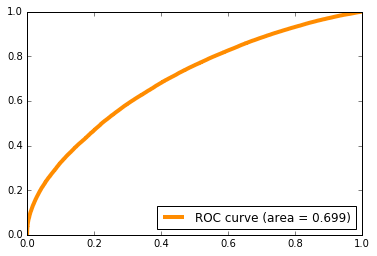

In [14]:
fpr, tpr, _ = roc_curve(test["IsArrDelayed"], test["IsArrDelayedPred"])
AUC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=4, label='ROC curve (area = %0.3f)' % AUC)
plt.legend(loc=4)

In [15]:
AUC

0.69916469257904157

## Key takeaways

- We built a GLM model predicting airline delay probability in tensorflow
- We train it on 800K rows in ~10sec on an intel i7-6700K (4.0 GHz) with a GTX970 GPU
- We measure an AUC of 0.699, which is almost identical to python-3 scikit learn results
- We demonstrated a typical workflow in python+tensorflow in a Jupyter notebook
- The boost in performance with respect to scikit-learn is minimal, but this is because the logistic regression model is so simple that the majority of time is spent in transfering the data from/to the graphic card.
- We can easilly customize the model using tensorflow graph operation with no additional pain in either complexity or computing performance.


Tensorflow documentation is quite complete and contains several examples from linear algebra to advance deep learning techniques.